In [19]:
import random

from matplotlib import pyplot as plt
from torch import Tensor

from embeddings.common.log import logger
from embeddings.dataset.tno_dataset_collection import TnoDatasetCollection
from embeddings.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from embeddings.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from embeddings.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    GenerativeModelSolver,
    SparsityTransform,
)
from embeddings.models.common.metrics import mse, relative_error, ssim
from embeddings.plotting.city_emission_field_plot import plot_emission_field_tensor

In [20]:
def load_data(city: str) -> Tensor:
    dataset = TnoDatasetCollection().get_case_study_data(city=city, year=2018)
    dataset.disable_temporal_transforms()
    return dataset[random.randint(0, len(dataset) - 1)].sum(dim=0)

In [21]:
x = load_data("Paris")

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                          
	Aachen, Gdynia, Magdeburg, Innsbruck, Győr, Hamburg, Siegen, Großzschocher, Prague, Reims, Duisburg, Szczecin, Dresden
[INFO] > Validation Set has 15 unique cites!
	Wałbrzych, Linz, Kalisz, Southampton, Bielefeld, Koblenz, Bydgoszcz, Nijmegen, Brussels, Zielona Góra, Erfurt, Kassel, Angers, Frankfurt am Main, Ingolstadt
[INFO] > Training Set has 74 unique cites!
	Norwich, Nancy, Groningen, Regensburg, Ostrava, Amiens, Milton Keynes, Sunderland, Chemnitz, Köln, Odense, Charleroi, Salzburg, Liberec, Brugge, Ulm, Bremerhaven, Augsburg, Gorzów Wielkopolski, Leeds, Pilsen, Trier, Münster, Enschede, Legnica, Brno, Bremen, Kiel, Koszalin, Li

In [22]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=50)

snr = 10_000

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x,
    Tensor(sensing_matrix),
    snr=snr
)

In [23]:
bp_solver = BasisPursuitSolver(verbose=False)
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT, verbose=False)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT, verbose=False)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)


Interrupt request received


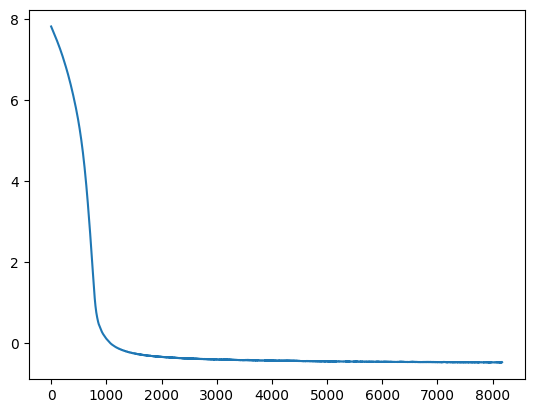

In [24]:
x_rec = problem.solve(gen_solver_2048_munich)

In [25]:
logger.info(f"MSE={mse(x, x_rec):.3f}")
logger.info(f"SSIM={ssim(x, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec):.3f}%")

[INFO] > MSE=12.659
[INFO] > SSIM=0.541
[INFO] > Relative Error=47.155%


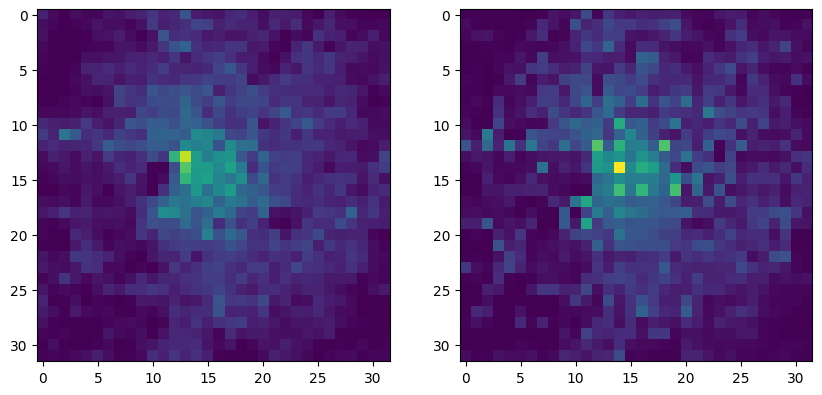

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmax = 1.1 * float(x.max())

plot_emission_field_tensor(ax=ax1, emission_field=x, vmax=vmax)
plot_emission_field_tensor(ax=ax2, emission_field=x_rec, vmax=vmax)